In [2]:
import os
import sys
from dotenv import load_dotenv
load_dotenv() 

# Set the target folder name you want to reach
target_folder = "NCEAS_Unsupervised_NLP"

# Get the current working directory
current_dir = os.getcwd()

# Loop to move up the directory tree until we reach the target folder
while os.path.basename(current_dir) != target_folder:
    parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
    if parent_dir == current_dir:
        # If we reach the root directory and haven't found the target, exit
        raise FileNotFoundError(f"{target_folder} not found in the directory tree.")
    current_dir = parent_dir

# Change the working directory to the folder where "phate-for-text" is found
os.chdir(current_dir)

# Add the "phate-for-text" directory to sys.path
sys.path.insert(0, current_dir)

In [5]:
# Move to repo root
target_folder = "NCEAS_Unsupervised_NLP"
current_dir = os.getcwd()

while os.path.basename(current_dir) != target_folder:
    parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
    if parent_dir == current_dir:
        raise FileNotFoundError(f"{target_folder} not found.")
    current_dir = parent_dir

os.chdir(current_dir)

# Add repo root
sys.path.insert(0, current_dir)

# Add src so custom_packages works
sys.path.insert(0, os.path.join(current_dir, "src"))


In [6]:
# ===================
# Standard Libraries
# ===================
import importlib
import os
import re
import warnings
from collections import defaultdict

# ===================
# Data Manipulation
# ===================
import numpy as np
import pandas as pd

# ==========================
# Dimensionality Reduction
# ==========================
import phate
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP   # Safe import (no TensorFlow)

# ========================
# Clustering
# ========================
import hdbscan
from hdbscan import HDBSCAN
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from custom_packages.diffusion_condensation import DiffusionCondensation as dc

# ======================
# Evaluation Metrics
# ======================
from custom_packages.fowlkes_mallows import FowlkesMallows
from sklearn.metrics import adjusted_rand_score, rand_score

from tqdm import tqdm

# ==============
# Global Config
# ==============
np.random.seed(42)
warnings.filterwarnings("ignore")

importlib.reload(phate)


<module 'phate' from '/opt/anaconda3/lib/python3.12/site-packages/phate/__init__.py'>

In [9]:
df = pd.read_csv("src/data/arxiv/data/arxiv/arxiv_30k_clean.csv")
df_new = pd.DataFrame()
df_new["topic"] = df["text"]
df_new["category_1"] = df["label"]
df_new["category_0"] = df["label"].apply(lambda x: x.split(".")[0])

df_new = df_new.dropna().reset_index(drop=True)

In [37]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

def get_embeddings(texts, model_name="Qwen/Qwen3-Embedding-0.6B", batch_size=64):
    """
    Generate embeddings using Qwen locally.
    """
    model = SentenceTransformer(model_name)

    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Qwen embeddings"):
        batch = texts[i:i+batch_size]
        batch_embeds = model.encode(
            batch,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        embeddings.append(batch_embeds)

    return np.vstack(embeddings)


In [38]:
embedding_model = "qwen3-0.6b"
os.makedirs("qwen_embeddings", exist_ok=True)

embedding_list = get_embeddings(df_new["topic"].tolist())
np.save("qwen_embeddings/arxiv_embed_test.npy", embedding_list)

Fetching GPT embeddings: 100%|██████████| 804/804 [32:09<00:00,  2.40s/batch]


In [19]:
embedding_list = np.load("qwen_embeddings/arxiv_embed_benchmarkdbpedia_test.npy")

In [ ]:
os.makedirs(f"{embedding_model}_reduced_embeddings", exist_ok=True)

In [20]:
shuffle_idx = np.random.RandomState(seed=42).permutation(len(df))
# Shuffle both documents and embeddings using the same index
topic_data = df.iloc[shuffle_idx].reset_index(drop=True)
data = np.array(embedding_list)[shuffle_idx] 
reverse_idx = np.argsort(shuffle_idx)

In [21]:
topic_dict = {}

for col in topic_data.columns:
    if re.match(r'^category_\d+$', col):
        topic_dict[col] = np.array(topic_data[col])


In [22]:
reducer_model = phate.PHATE(
    n_jobs=-1,
    random_state=42,
    n_components=50,
    decay=20,
    t="auto",
    n_pca=100   # optional speedup
)



Calculating PHATE...
  Running PHATE on 60794 observations and 3072 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.37 seconds.
  Calculated graph and diffusion operator in 6.37 seconds.
Calculated PHATE in 6.37 seconds.


KeyboardInterrupt: 

In [44]:
np.save(
    f"{embedding_model}_reduced_embeddings/PHATE_dbpedia_embed_test.npy",
    embed_phate)



In [24]:
embed_phate = np.load(
    f"{embedding_model}_reduced_embeddings/PHATE_dbpedia_embed_test.npy"
)


In [25]:
depth= 3
cluster_levels=[]
for i in reversed(range(0, depth)):
    cluster_levels.append(len(topic_data[f'category_{i}'].unique()))


In [26]:

include_pca =True
include_umap=True

# Load your embeddings
embeddings = np.array(data)
embedding_methods = {}
# PCA to 2D

embedding_methods["PHATE"]  =embed_phate

In [49]:

if include_pca:
    pca = PCA(n_components=50)
    embedding_methods["PCA"] = pca.fit_transform(embeddings)
np.save(
    f"{embedding_model}_reduced_embeddings/PCA_arxiv_embed_test.npy",
    embedding_methods["PCA"]
)


In [27]:

# # UMAP to 2D
if include_umap:
    umap_model = UMAP(
        n_components=50,
        random_state=42,
        min_dist=0.05,
        n_neighbors=10
    )

    embedding_methods["UMAP"] = umap_model.fit_transform(embeddings)

    np.save(
        f"{embedding_model}_reduced_embeddings/UMAP_arxiv_embed_test.npy",
        embedding_methods["UMAP"]
    )


In [51]:

from sklearn.manifold import TSNE

# Fit t-SNE
tsne_model = TSNE(n_components=3, random_state=42,n_jobs=-2)
embedding_methods["tSNE"] = tsne_model.fit_transform(embeddings)
np.save(f"{embedding_model}_reduced_embeddings/tSNE_dbpedia_embed_test.npy",embedding_methods["tSNE"])

: 

In [28]:
embedding_methods["PCA"] = np.load(
    f"{embedding_model}_reduced_embeddings/PCA_arxiv_embed_test.npy"
)

embedding_methods["UMAP"] = np.load(
    f"{embedding_model}_reduced_embeddings/UMAP_arxiv_embed_test.npy"
)


In [29]:
import gc
scores_all = defaultdict(lambda: defaultdict(list))
labels=None
model=None
for embed_name, embed_data in embedding_methods.items():

    for cluster_method in ["Agglomerative", "HDBSCAN", "DC"]:

        for level in cluster_levels:

            if cluster_method == "Agglomerative":
                model = AgglomerativeClustering(n_clusters=level)
                labels = model.fit_predict(embed_data)

            elif cluster_method == "HDBSCAN":
                model = hdbscan.HDBSCAN(min_cluster_size=10)
                model.fit(embed_data)

                Z = model.single_linkage_tree_.to_numpy()
                labels = fcluster(Z, level, criterion='maxclust')
                labels[labels == -1] = labels.max() + 1

            elif cluster_method == "DC":
                model = dc(min_clusters=level, max_iterations=5000, k=10, alpha=4, t=3)
                model.fit(embed_data)
                labels = model.labels_

            topic_series = topic_dict[level]
            valid_idx = ~pd.isna(topic_series)

            target_lst = topic_series[valid_idx]
            label_lst = labels[valid_idx]

            try:
                fm_score = FowlkesMallows.Bk(
                    {level: target_lst},
                    {level: label_lst}
                )[level]['FM']
            except:
                fm_score = np.nan

            scores_all[(embed_name, cluster_method)]["FM"].append(fm_score)
            scores_all[(embed_name, cluster_method)]["Rand"].append(
                rand_score(target_lst, label_lst)
            )
            scores_all[(embed_name, cluster_method)]["ARI"].append(
                adjusted_rand_score(target_lst, label_lst)
            )


In [31]:
rows = []

for (embed_name, cluster_method), score_list in scores_all.items():
    for score in score_list:
        rows.append({
            "reduction_method": embed_name,
            "cluster_method": cluster_method,
            "level": score["level"],
            "FM": score["FM"],
            "Rand": score["Rand"],
            "ARI": score["ARI"],
        })


In [31]:
import json
with open("combo_color_map.json", 'r') as file:
        combo_color_map = json.load(file)

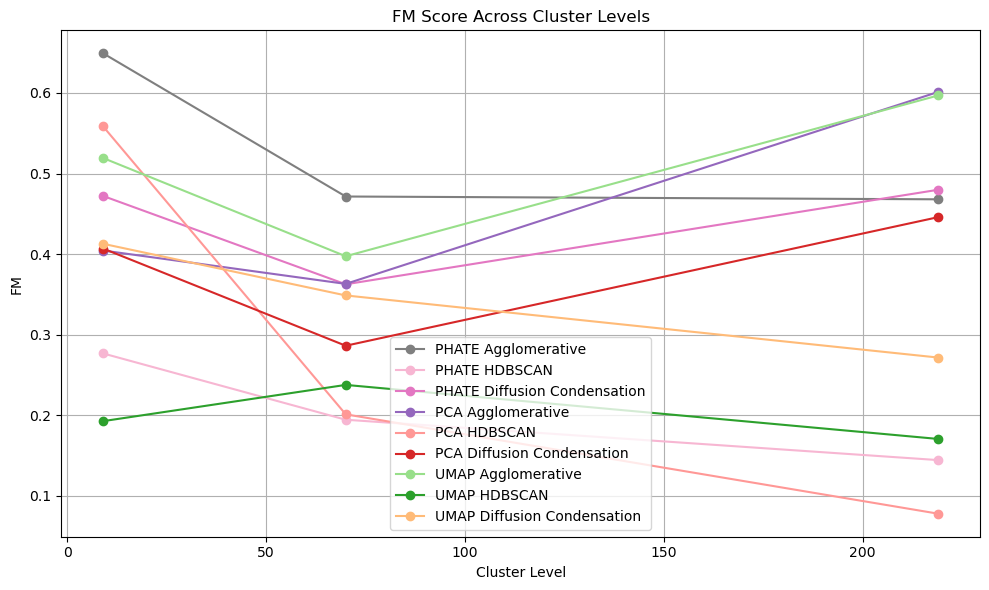

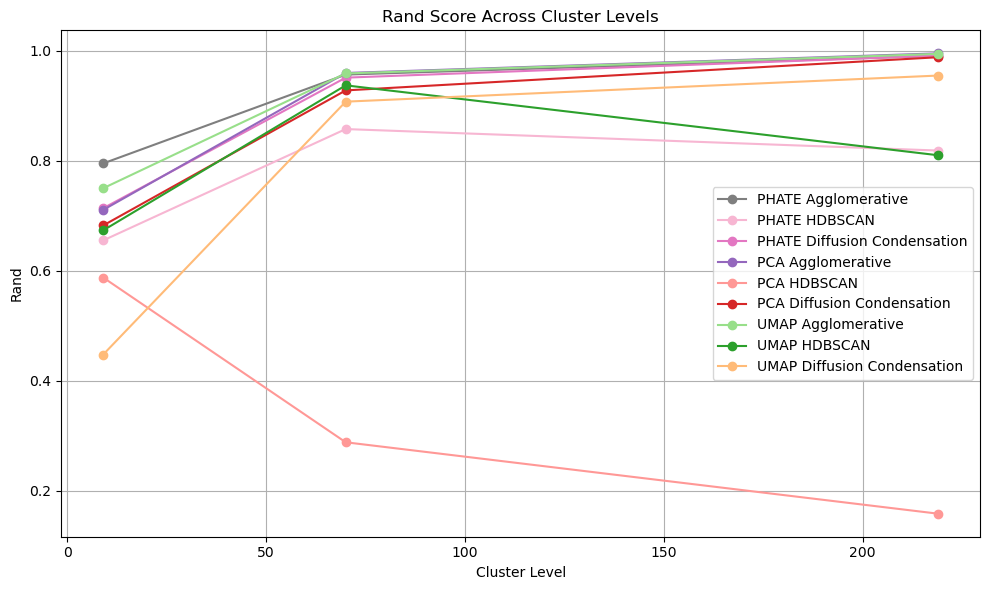

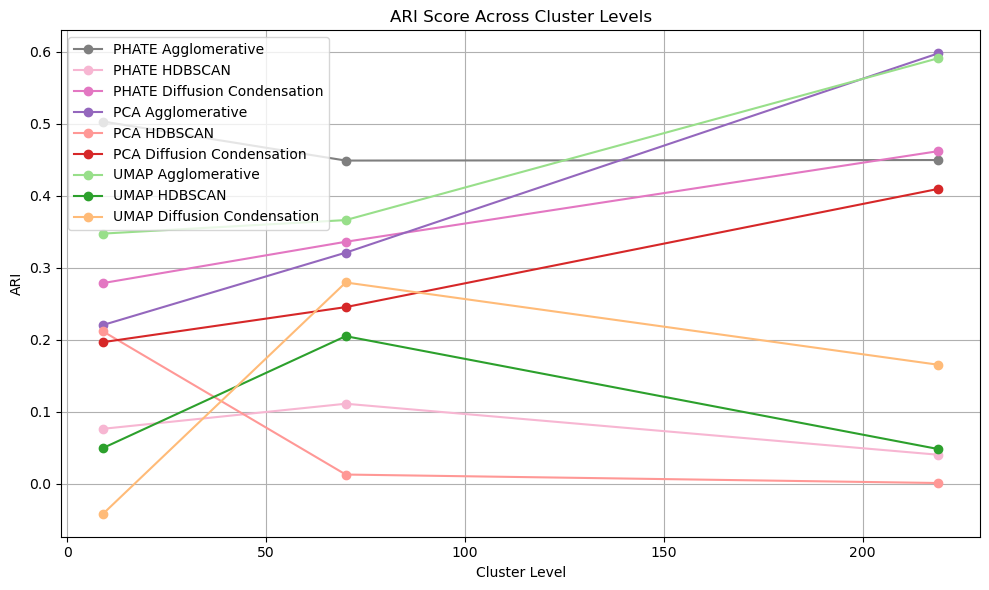

In [32]:
import matplotlib.pyplot as plt

metrics = ["FM", "Rand", "ARI"]

for metric in metrics:
    plt.figure(figsize=(10, 6))

    for (embed_name, method), metric_scores in scores_all.items():

        display_method = (
            "Diffusion Condensation"
            if method == "DC"
            else method
        )

        combo_key = f"{embed_name}_{display_method}"

        plt.plot(
            cluster_levels,
            metric_scores[metric],
            marker="o",
            label=f"{embed_name} {display_method}",
            color=combo_color_map.get(combo_key, "black")
        )

    plt.title(f"{metric} Score Across Cluster Levels")
    plt.xlabel("Cluster Level")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
